In [3]:
import pandas as pd
import numpy as np
import math
import gc
import os
import random

# Data Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Manipulation
from collections import defaultdict

# Vision
from PIL import UnidentifiedImageError, Image, ImageFilter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image
import cv2

# Order pictures
import os
import shutil

##  1. EDA (Exploratory Data Analysis)

### 1.1 Load CSV files containing the labels

In [4]:
# Path to dataset folder
data_path = "/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/data"
train_dir = "/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/data/train"
val_dir = "/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/data/valid"
test_dir = "/Users/marcosbeliera/Desktop/marcos-projects/01.challenges-interviews/challenge-rootstrap/2daa3ac1-1d6b-441d-ab21-6e4e06fe22a5/data/test"

# Load CSV files containing multilabel class annotations
df_train_labels = pd.read_csv("data/train/_classes.csv", sep=',')
df_val_labels = pd.read_csv("data/valid/_classes.csv", sep=',')
df_test_labels = pd.read_csv("data/test/_classes.csv", sep=',')

# Create copies to be used in dataset construction
train_labels = df_train_labels.copy()
test_labels = df_test_labels.copy()
val_labels = df_val_labels.copy()

# Preview structure of the train label dataframe
df_train_labels.head(10)

filename   Fishing Boat  \
0  merch_69_jpg.rf.d47166fb68ddfe520eea25dbdf3806...              1   
1  yacht_62_jpg.rf.d988bc6e7273ed218829e7ed2843b0...              0   
2  military_7_jpg.rf.d87cfcbf7547853acee0ca4af438...              1   
3  yacht_96_jpg.rf.d6db2c1d5b630e780389a00fcc411b...              0   
4  patrol_24_jpg.rf.d72aed545270e9115e9aea267417b...              1   
5  yacht_61_jpg.rf.dad88db3f6e284a730dbf314670988...              0   
6  patrol_52_jpg.rf.d756b8099565cd322f9feb2bf8aa8...              1   
7  military_96_jpg.rf.d63eca32ea64bd257c0ea16fc94...              1   
8  patrol_47_jpg.rf.d97da306eae9d1a0c183847fb5feb...              0   
9  patrol_30_jpg.rf.d0de7bafbbbba4fba7e0920ed3ee4...              0   

    Merchant Ship   Military Ship   Patrol Boat   Sails Boat   Submarine  \
0               1               1             0            0           0   
1               0               0             1            1           0   
2               0               1             1            0           0   
3               0               0             0            1           1   
4               1               0             1            1           0   
5               0               0             0            1           1   
6               0               1             1            0           0   
7               0               1             1            0           0   
8               1               1             1            0           0   
9               1               0             1            0           0   

    Tugboat   Yacht  
0         0       0  
1         0       1  
2         0       0  
3         0       1  
4         0       0  
5         0       1  
6         0       0  
7         0       0  
8         0       0  
9         0       0

In [5]:
# See columns
print(df_train_labels.columns)
print(df_val_labels.columns)
print(df_test_labels.columns)

Index(['filename', ' Fishing Boat', ' Merchant Ship', ' Military Ship',
       ' Patrol Boat', ' Sails Boat', ' Submarine', ' Tugboat', ' Yacht'],
      dtype='object')
Index(['filename', ' Fishing Boat', ' Merchant Ship', ' Military Ship',
       ' Patrol Boat', ' Sails Boat', ' Submarine', ' Tugboat', ' Yacht'],
      dtype='object')
Index(['filename', ' Fishing Boat', ' Merchant Ship', ' Military Ship',
       ' Patrol Boat', ' Sails Boat', ' Submarine', ' Tugboat', ' Yacht'],
      dtype='object')


<div class="alert alert-success" role="alert">

We have 8 classes in the dataset with the columns shown.

### 1.2 Analyze class balance by split

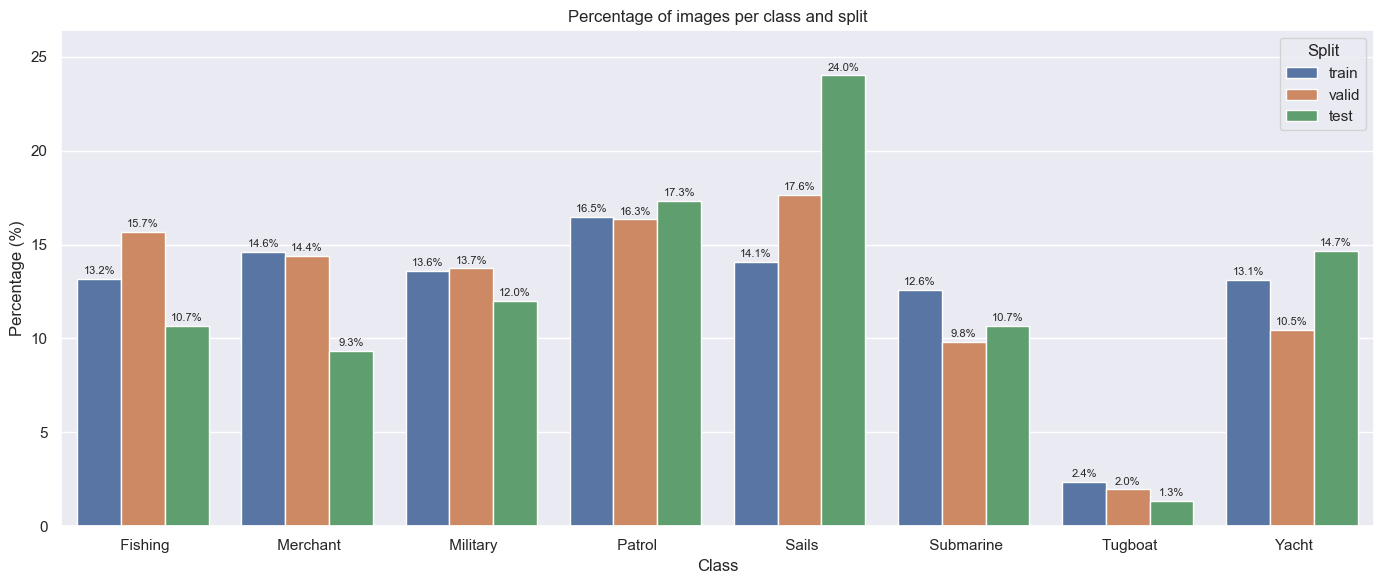

In [6]:
# Group the three label DataFrames by split
splits = {
    'train': df_train_labels,
    'valid': df_val_labels,
    'test':  df_test_labels
}

# Get all class columns (excluding 'filename')
class_columns = df_train_labels.columns[1:]

plot_data = []
for split_name, df in splits.items():
    # Total number of positive labels (sum of ONES across all classes)
    total_objects = int(df[class_columns].sum().sum())
    
    for class_name in class_columns:
        count = int(df[class_name].sum())
        pct   = count / total_objects * 100
        plot_data.append({
            'Class': class_name.replace(' Ship', '').replace(' Boat', ''),
            'Percentage (%)': pct,
            'Split': split_name
        })

df_plot = pd.DataFrame(plot_data)

# ——— Plotting ———
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=df_plot, x='Class', y='Percentage (%)', hue='Split', ax=ax)

# Annotate each bar with its percentage
for bar in ax.patches:
    h = bar.get_height()
    if h > 0:
        ax.annotate(
            f'{h:.1f}%',
            xy=(bar.get_x() + bar.get_width()/2, h),
            xytext=(0, 2), textcoords="offset points",
            ha='center', va='bottom', fontsize=8
        )

ax.set_title("Percentage of images per class and split")
ax.set_ylim(0, df_plot['Percentage (%)'].max() * 1.1)
plt.tight_layout()
plt.show()


<div class="alert alert-success" role="alert">

* The **Tugboat** class is significantly underrepresented across all splits, which may affect the model's accuracy if balancing techniques are not applied.
* The **Sails** class is overrepresented in the test set, which could impact metrics if the model is overfitted to that class.
* Balancing should only be done on the training set: applying it to validation or test distorts real-world evaluation.
* The model may misclassify minority classes if they're underrepresented during training.

### 1.3 Images Visualization

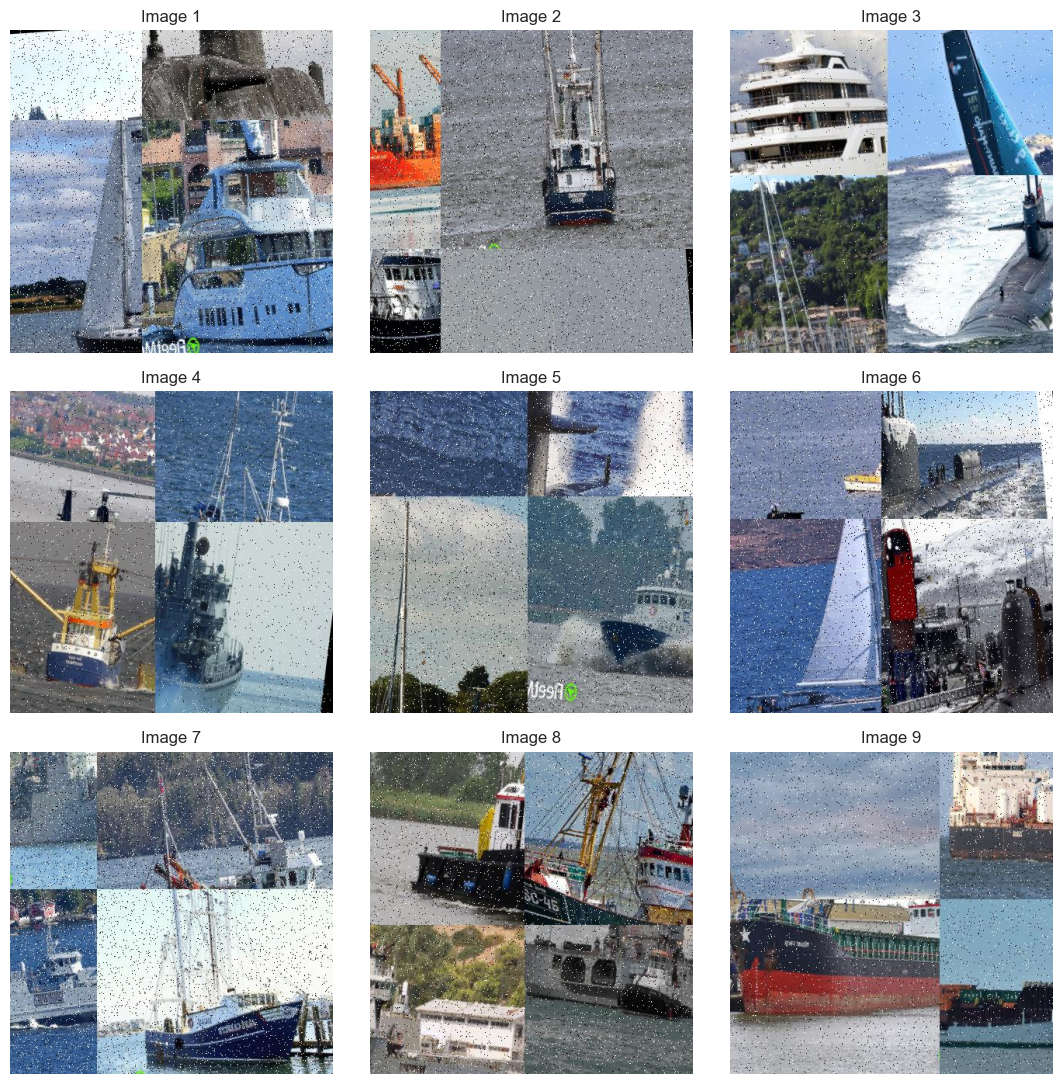

In [7]:
### TRAIN

# Número de imágenes a mostrar
num_samples = 9
image_files = os.listdir(train_dir)

# Elegir imágenes aleatorias
rand_images = random.sample(image_files, num_samples)

# Crear grid 3x3
fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(train_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

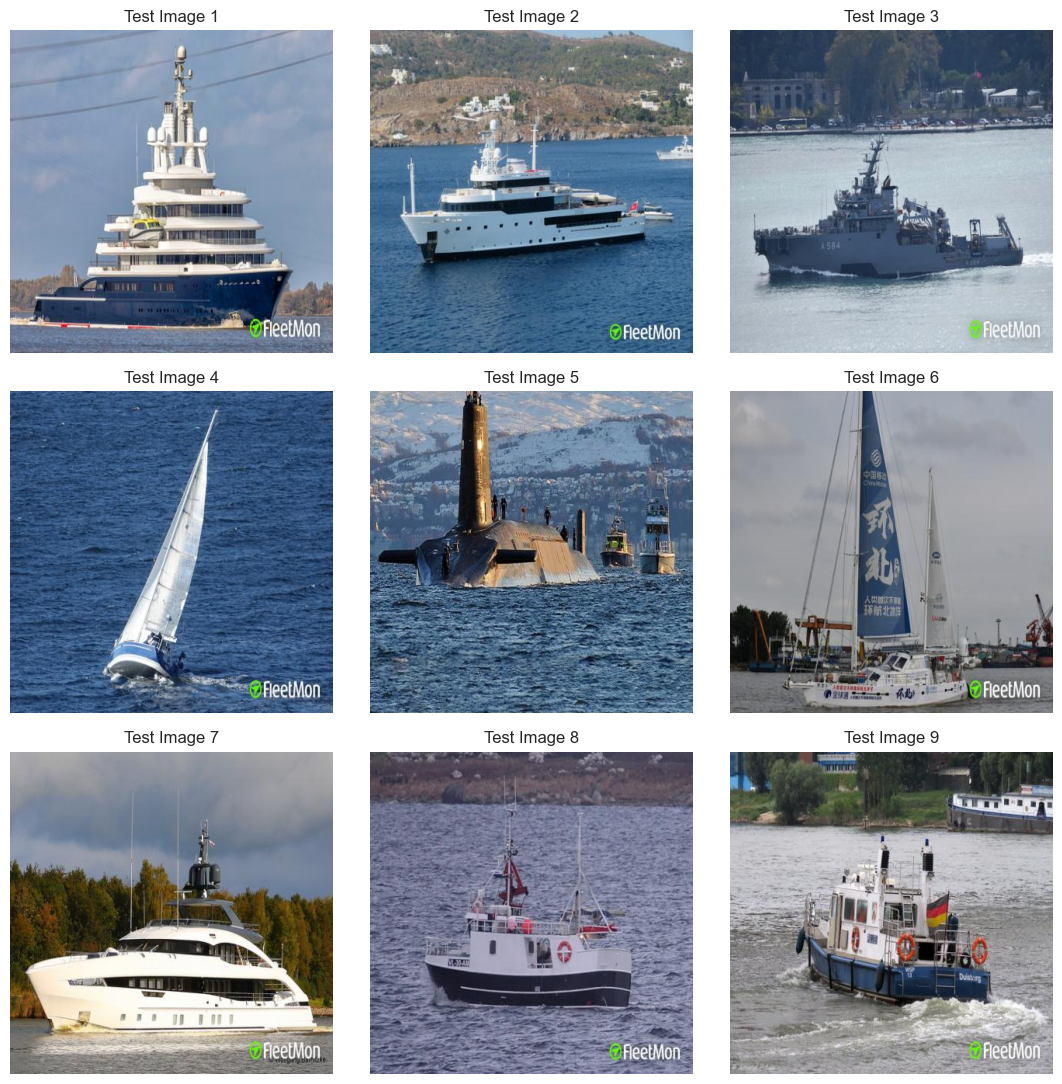

In [9]:
### TEST

# Number of images to display
num_samples = 9
test_image_files = os.listdir(test_dir)

# Select random images
rand_test_images = random.sample(test_image_files, num_samples)

# Create 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_test_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(test_dir, image)))
    ax.set_title(f'Test Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


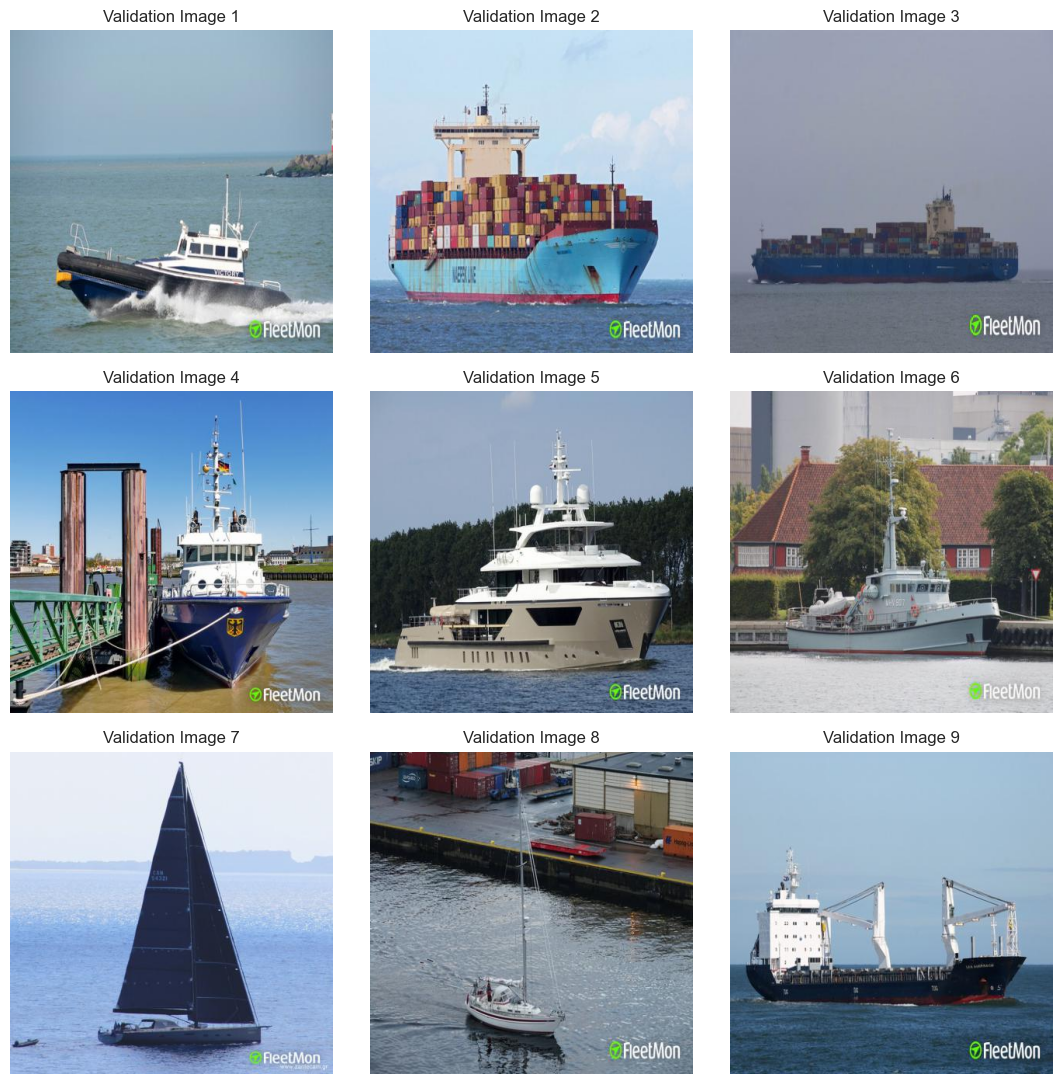

In [10]:
### VALIDATION

# Number of images to display
num_samples = 9
val_image_files = os.listdir(val_dir)

# Select random images
rand_val_images = random.sample(val_image_files, num_samples)

# Create 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_val_images[i]  # <- corregido aquí
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(val_dir, image)))
    ax.set_title(f'Validation Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-success" role="alert">

The training images are split into four smaller sections, which can fragment the objects. Using a model like YOLO, which is designed to detect and localize entire objects, could help better capture and learn from these partial views.


Before using YOLO, we will start with an analysis using ResNet to evaluate how the model responds to the current dataset structure. This will provide a baseline before moving on to object detection.

### 1.4 Amount of channels and size

In [11]:
splits = ['train', 'valid', 'test']
num_samples = 3  # Número de imágenes a revisar por split

# Recorrer cada split
for split in splits:
    print(f"\n📁 {split.upper()} IMAGES:")

    # Directorio correspondiente al split actual
    image_dir = os.path.join(data_path, split)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Seleccionar imágenes al azar
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))

    for img_name in sample_images:
        path = os.path.join(image_dir, img_name)
        image = cv2.imread(path)

        if image is not None:
            h, w, c = image.shape
            print(f"🖼️ {img_name} — {w}x{h}, {c} channels")
        else:
            print(f"⚠️ Failed to load {img_name}")


📁 TRAIN IMAGES:
🖼️ yacht_30_jpg.rf.b5ef4823dafccce72d823859974d0bcd.jpg — 416x416, 3 channels
🖼️ yacht_71_jpg.rf.aa85f99b5fa561d1829e4eaf7a812a91.jpg — 416x416, 3 channels
🖼️ patrol_45_jpg.rf.de47f43350f3ac021d725029952c2a05.jpg — 416x416, 3 channels

📁 VALID IMAGES:
🖼️ military_57_jpg.rf.5a65ba946f5b7d4754318d2097049c19.jpg — 416x416, 3 channels
🖼️ fish_32_jpg.rf.c415e94d763099b6cb6b04a848644f16.jpg — 416x416, 3 channels
🖼️ patrol_43_jpg.rf.4e1dc380c87ec7a0172c217307763f39.jpg — 416x416, 3 channels

📁 TEST IMAGES:
🖼️ sub_85_jpg.rf.117cde2551a004550a747812bbce52c1.jpg — 416x416, 3 channels
🖼️ sails_19_jpg.rf.2b613291bd79d1e2a00d06c96edca85f.jpg — 416x416, 3 channels
🖼️ sails_82_jpg.rf.a81ca21e9fd80f93b4306696c609cab7.jpg — 416x416, 3 channels


In [12]:
splits = ['train', 'valid', 'test']
num_samples = 3  # Número de imágenes a revisar por split

for split in splits:
    print(f"\n📁 {split.upper()} IMAGES:")

    image_dir = os.path.join(data_path, split)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    sample_images = random.sample(image_files, min(num_samples, len(image_files)))

    for img_name in sample_images:
        path = os.path.join(image_dir, img_name)
        image = cv2.imread(path)

        if image is not None:
            h, w, c = image.shape
            aspect_ratio = round(w / h, 2)
            print(f"🖼️ {img_name} — {w}x{h}, {c} channels, Aspect Ratio: {aspect_ratio}")
        else:
            print(f"⚠️ Failed to load {img_name}")



📁 TRAIN IMAGES:
🖼️ sub_12_jpg.rf.a1bbfc8f944d98bcf2d694af2331b775.jpg — 416x416, 3 channels, Aspect Ratio: 1.0
🖼️ military_52_jpg.rf.c1cfcd8ccff5be7c8953428448873754.jpg — 416x416, 3 channels, Aspect Ratio: 1.0
🖼️ merch_57_jpg.rf.54431c505d37f496b3fa9d2d85eed06d.jpg — 416x416, 3 channels, Aspect Ratio: 1.0

📁 VALID IMAGES:
🖼️ sails_50_jpg.rf.1fb9cbec36c9f8a59d700eb8f5627e0a.jpg — 416x416, 3 channels, Aspect Ratio: 1.0
🖼️ military_12_jpg.rf.c7dfcbf12a92305e077cf8a86b39d52c.jpg — 416x416, 3 channels, Aspect Ratio: 1.0
🖼️ merch_68_jpg.rf.2bbe117724b6cbe28fc42206b8f86524.jpg — 416x416, 3 channels, Aspect Ratio: 1.0

📁 TEST IMAGES:
🖼️ sails_38_jpg.rf.ac412e26a5f08192b32164623f96695b.jpg — 416x416, 3 channels, Aspect Ratio: 1.0
🖼️ fish_1_jpg.rf.3d78a162e23dd349a3ed5a5aa3bd1589.jpg — 416x416, 3 channels, Aspect Ratio: 1.0
🖼️ fish_74_jpg.rf.a64272807d8fcc1145ffe7160a8c5eb7.jpg — 416x416, 3 channels, Aspect Ratio: 1.0


<div class="alert alert-success" role="alert">

- Images have the same dimensions: **416×416 pixels**.  
- They all have **3 channels** (RGB), making them suitable for CNN models.  
- Images have an **aspect ratio of 1.0**, indicating a square format.  
- This consistent format simplifies preprocessing and allows for data augmentation without distortion.  
- No corrupted or unreadable images were found in the sampled examples.